# **Waze Project - Regression modeling**

# **Regression modeling**

**The goal** is to build a binomial logistic regression model and evaluate the model's performance.

**Part 1:** EDA & Checking Model Assumptions

**Part 2:** Model Building and Evaluation

**Part 3:** Interpreting Model Results

# **Build a regression model**

# **PACE stages**

## **PACE: Plan**

### **Imports and data loading**

In [1]:
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, classification_report

In [2]:
# Load the dataset by running this cell

df = pd.read_csv('waze_dataset.csv')

## **PACE: Analyze**

### **Explore data with EDA**

In [3]:
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
df.info()

Dataset has 14999 rows and 13 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
me

The label column has 700 missing values out of 14,999 entries.

In [4]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


We will use `.drop()` to remove the ID column since we don't need this information for the analysis.

In [5]:
df.drop(columns=['ID'], axis=1, inplace=True)

Now, check the class balance of the dependent (target) variable, `label`.

In [6]:
df['label'].value_counts(normalize=True) 

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

In [7]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


Several variables potentially have outliers, as indicated by large differences between the 75th percentile and the maximum values, and high standard deviations:

- sessions (max: 743 vs. 75th percentile: 112)

- drives (max: 596 vs. 75th percentile: 93)

- total_sessions (max: 1216 vs. 75th percentile: 254)

- driven_km_drives (max: 21,183 km vs. 75th percentile: 5,290 km)

- duration_minutes_drives (max: 15,852 minutes vs. 75th percentile: 2,464 minutes)

- total_navigations_fav1 and fav2 also show potential outliers based on high max values relative to quartiles.

### **Create features**

Let's create features that may be of interest to the stakeholder and/or that are needed to address the business scenario/problem.

#### **`km_per_driving_day`**

We know from earlier EDA that churn rate correlates with distance driven per driving day in the last month. It might be helpful to engineer a feature that captures this information.

1. Let's create a new column in `df` called `km_per_driving_day`, which represents the mean distance driven per driving day for each user.

2. Call the `describe()` method on the new column.

In [8]:
# 1. Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Call `describe()` on the new column
df['km_per_driving_day'].describe()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

1. Convert these values from infinity to zero. We can use `np.inf` to refer to a value of infinity.

2. Call `describe()` on the `km_per_driving_day` column to verify that it worked.

In [9]:
# 1. Convert infinite values to zero
df['km_per_driving_day'] = df['km_per_driving_day'].replace(np.inf, 0)

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`professional_driver`**

Let's create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

In [10]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] > 60) & (df['driving_days'] >= 15), 1, 0)

Let's perform a quick inspection of the new variable.

1. Check the count of professional drivers and non-professionals

2. Within each class (professional and non-professional) calculate the churn rate

In [11]:
# Check count of professionals and non-professionals
print(df['professional_driver'].value_counts(normalize=True))

# Check in-class churn rate
df.groupby('professional_driver')['label'].value_counts(normalize=True).unstack()

professional_driver
0    0.829722
1    0.170278
Name: proportion, dtype: float64


label,churned,retained
professional_driver,,
0,0.198498,0.801502
1,0.075102,0.924898


The churn rate for professional drivers is 7.5%, while the churn rate for non-professionals is 19.8%. This seems like it could add predictive signal to the model.

## **PACE: Construct**

After analysis and deriving variables with close relationships, it is time to begin constructing the model.

### **Preparing variables**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
 12  km_per_driving_day       14999 non-null  float64
 13  professional_driver      14999 non-null  int64  
dtypes: float64(4), int64(8

Because we know from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, we will use the `dropna()` method to drop the rows that are missing this data.

In [13]:
# Drop rows with missing data in `label` column
df.dropna(inplace=True)

#### **Impute outliers**

Previously, we've determined that seven of the variables had clear signs of containing outliers:

* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`

For this analysis, we will impute the outlying values for these columns. Calculate the **95th percentile** of each column and change to this value any value in the column that exceeds it.


In [14]:
# Impute outliers
columns_with_outliers = ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1', 
                   'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']

for col in columns_with_outliers:
    perc95 = df[col].quantile(0.95)
    df[col] = df[col].clip(upper=perc95)

In [15]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.171341
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.376820
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


#### **Encode categorical variables**

In [16]:
# Create binary `label2` column
df['label2'] = df['label'].map({'retained': 0, 'churned': 1})

### **Determine whether assumptions have been met**

The following are the assumptions for logistic regression:

* Independent observations (This refers to how the data was collected.)

* No extreme outliers

* Little to no multicollinearity among X predictors

* Linear relationship between X and the **logit** of y

For the first assumption, we can assume that observations are independent for this project.

The second assumption has already been addressed.

The last assumption will be verified after modeling.

#### **Collinearity**

For checking the correlation among predictor variables we need first to generate a correlation matrix.

In [17]:
# Generate a correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()

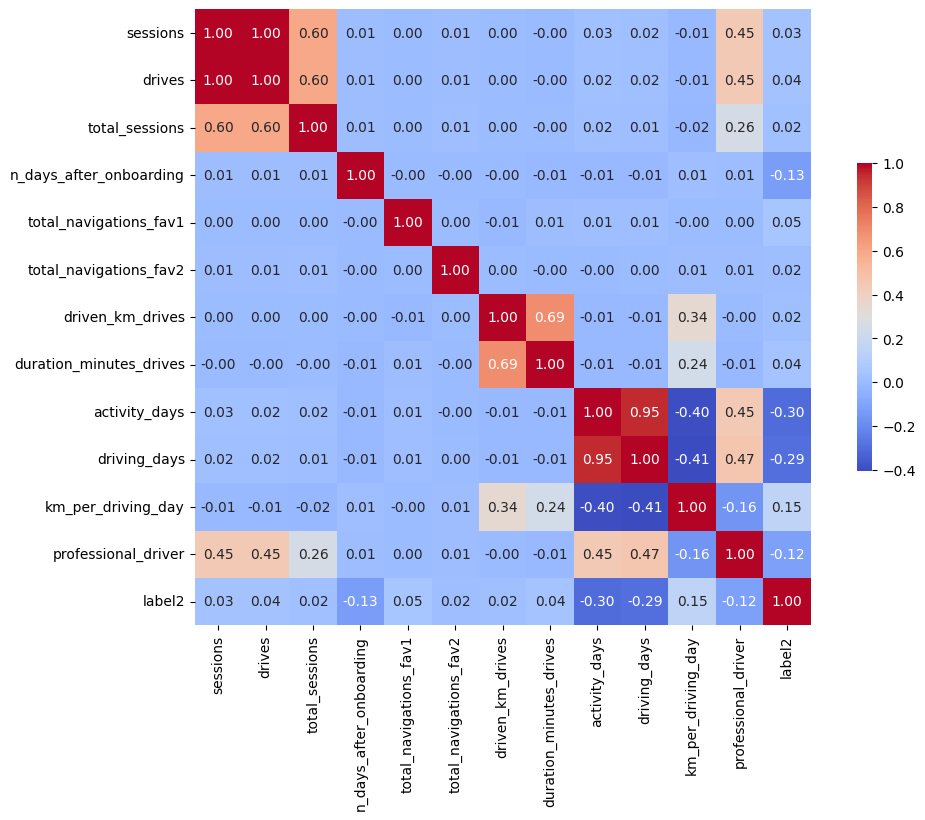

In [18]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': .5})
plt.show()

If there are predictor variables that have a Pearson correlation coefficient value greater than the **absolute value of 0.7**, these variables are strongly multicollinear. Therefore, only one of these variables should be used in the model.


**Strong Multicollinearity (|r| > 0.7):**

- sessions ↔ drives:
Correlation = 0.997 (very high)

- activity_days ↔ driving_days:
Correlation = 0.948 (very high)

- driven_km_drives ↔ duration_minutes_drives:
Correlation = 0.691 (close to threshold, still worth considering depending on the context)

Based on the strong multicollinearity found, we should consider dropping the following columns to avoid redundancy in our logistic regression model:

**Columns to Drop:**

- sessions (due to high correlation with drives)

- driving_days (due to high correlation with activity_days)

### **Create dummies**

While we have selected `device` as an X variable, we will need to create dummy variables since this variable is categorical.

Because this dataset only has one remaining categorical feature (`device`), it's not necessary to use one of these special functions. We can just implement the transformation directly.

In [19]:
# Create new `device2` variable
df['device2'] = df['device'].map({'Android': 0, 'iPhone': 1})

### **Model building**

#### **Assign predictor variables and target**

In [20]:
# Isolate predictor variables
X = df.drop(columns=['label', 'label2', 'device', 'sessions', 'driving_days'])

Now, isolate the dependent (target) variable. Assign it to a variable called `y`.

In [21]:
# Isolate target variable
y = df['label2']

#### **Split the data**

In [22]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42, stratify=y)

In [23]:
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
14856,27,136.343958,1771,4,0,3221.389287,2121.499575,27,169.546805,0,0
7054,108,270.075038,1435,422,0,4945.684532,1484.348106,10,618.210567,0,1
14587,82,199.305743,393,324,105,2692.758040,697.055702,16,192.339860,0,1
6693,52,267.417571,303,97,1,3249.284264,1898.107018,8,406.160533,0,0
3390,40,111.953141,3220,164,0,2354.134277,1656.119327,11,235.413428,0,1


Let's use scikit-learn to instantiate a logistic regression model. 

It is important to add `penalty = None` since our predictors are unscaled.

In [24]:
clf = LogisticRegression(penalty=None, max_iter=1000).fit(X_train, y_train)

In [25]:
clf.coef_

array([[ 2.35471784e-03,  4.32081938e-04, -3.98627610e-04,
         1.22294139e-03,  9.62674813e-04, -1.43900873e-05,
         1.16964354e-04, -1.03446269e-01,  1.95724181e-05,
        -9.22905739e-02,  3.97330709e-03]])

In [26]:
clf.intercept_

array([-0.10784694])

#### **Check final assumption**

Let's verify the linear relationship between X and the estimated log odds (known as logits) by making a regplot.

We can call the model's `predict_proba()` method to generate the probability of response for each sample in the training data. (The training data is the argument to the method.) Then assign the result to a variable called `training_probabilities`. This results in a 2-D array where each row represents a user in `X_train`. The first column is the probability of the user not churning, and the second column is the probability of the user churning.

In [27]:
# Get the predicted probabilities of the training data
training_probabilities = pd.DataFrame(clf.predict_proba(X_train), columns=['p', '1-p'])
training_probabilities[:3]

,p,1-p
0,0.963539,0.036461
1,0.670122,0.329878
2,0.748873,0.251127


In logistic regression, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. Here is the formula for calculating log-odds, where _p_ is the probability of response:
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>
 Next steps:
1. Create a dataframe called `logit_data` that is a copy of `df`.

2. Create a new column called `logit` in the `logit_data` dataframe. The data in this column should represent the logit for each user.


In [28]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data  = df.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = np.log(training_probabilities['p'] / training_probabilities['1-p'])
logit_data.head(3)

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,professional_driver,label2,device2,logit
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,1,0,0,3.274383
1,retained,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,iPhone,1246.901868,0,0,1,0.708735
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0,0,0,1.092611


Plot a regplot where the x-axis represents an independent variable and the y-axis represents the log-odds of the predicted probabilities.

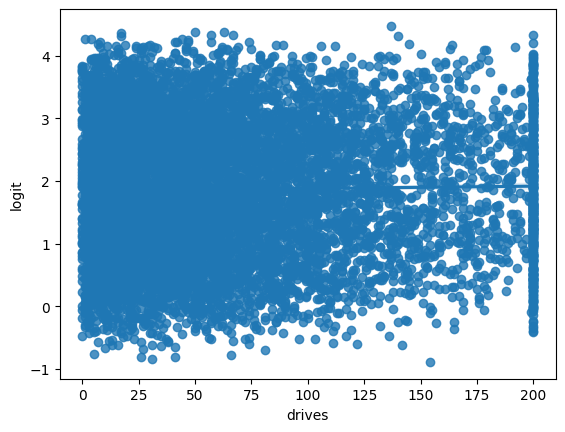

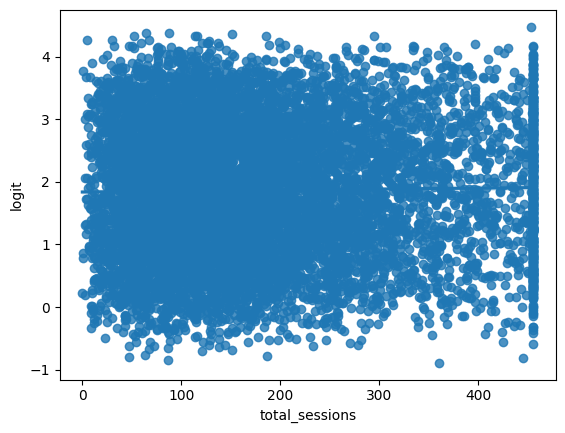

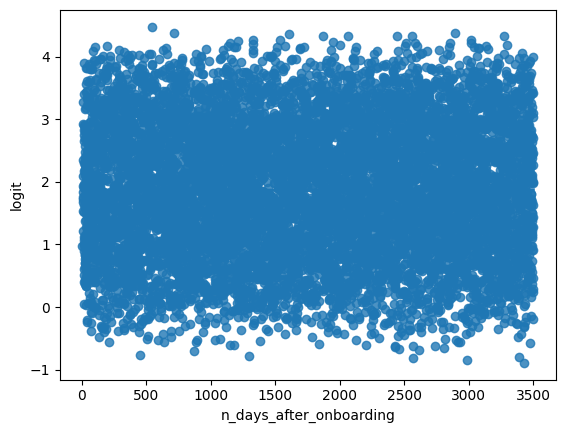

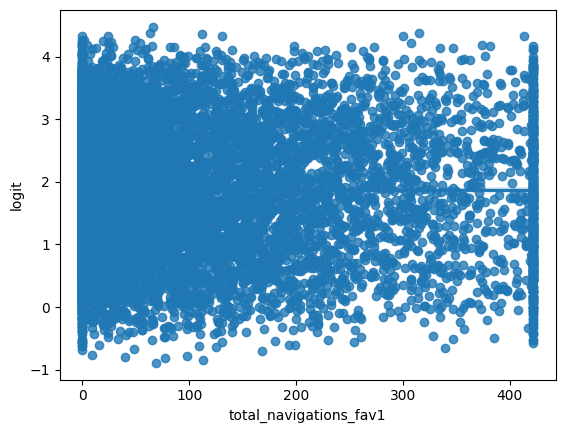

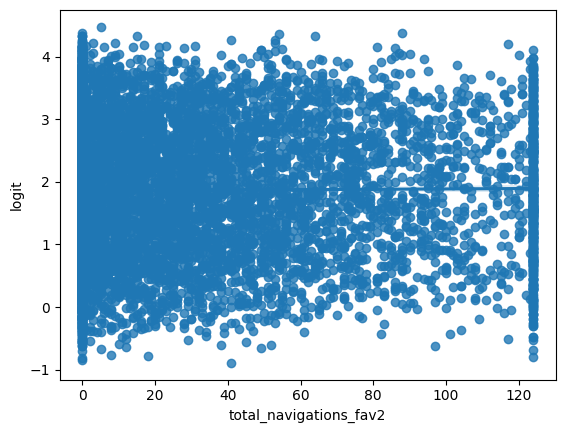

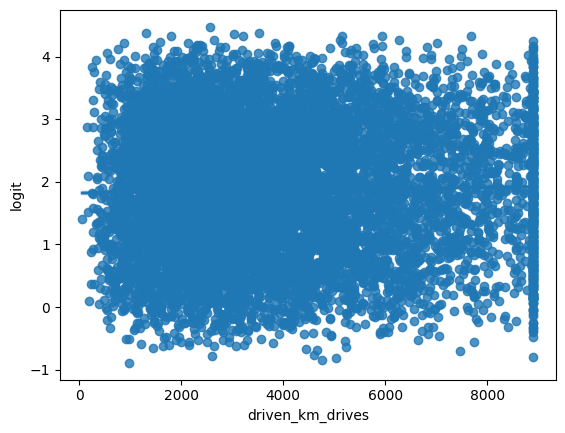

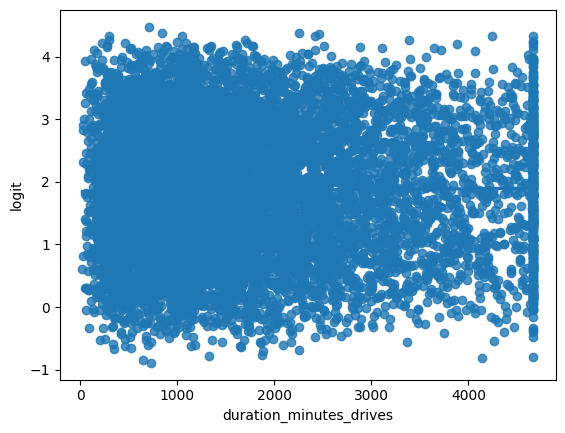

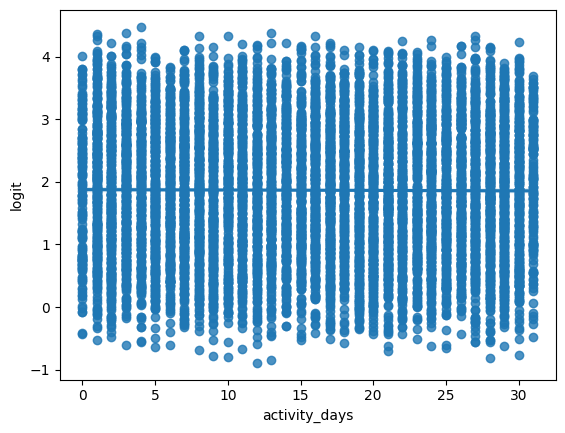

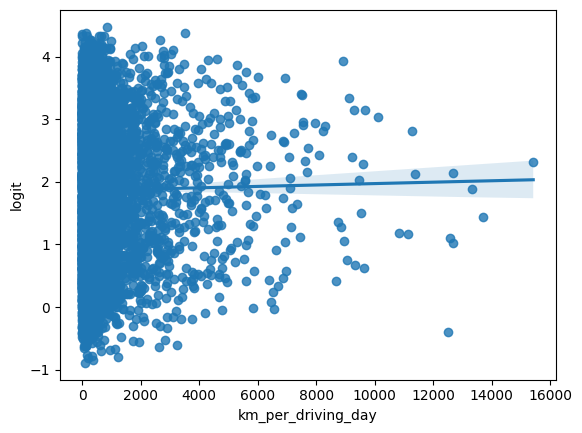

In [29]:
# Plot regplot of `activity_days` log-odds
columns = ['drives', 'total_sessions', 'n_days_after_onboarding', 'total_navigations_fav1', 
           'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives', 
           'activity_days', 'km_per_driving_day']

for col in columns:
    sns.regplot(x=col, y='logit', data=logit_data, logistic=False)
    plt.show()

## **PACE: Execute**

### **Results and evaluation**

If the logistic assumptions are met, the model results can be appropriately interpreted.

In [30]:
# Generate predictions on X_test
y_pred = clf.predict(X_test)

In [31]:
# Score the model (accuracy) on the test data
clf.score(X_test, y_test)

0.8243271879635516

### **Show results with a confusion matrix**

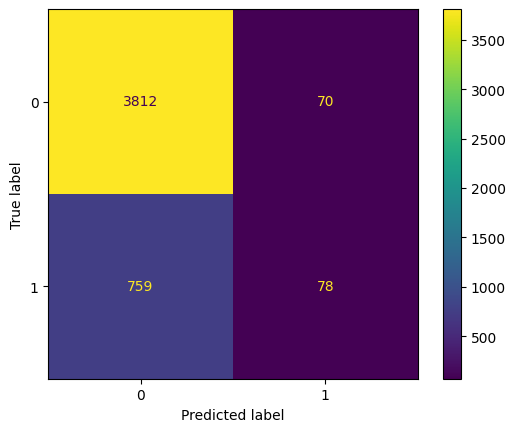

In [32]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [33]:
# Calculate precision
print(f"Precision score: {precision_score(y_test, y_pred)}")

Precision score: 0.527027027027027


In [34]:
# Calculate recall
print(f"Recall score: {recall_score(y_test, y_pred)}")

Recall score: 0.0931899641577061


In [35]:
# Create a classification report
print(f"Classification report: \n\n {classification_report(y_test, y_pred)}")

Classification report: 

               precision    recall  f1-score   support

           0       0.83      0.98      0.90      3882
           1       0.53      0.09      0.16       837

    accuracy                           0.82      4719
   macro avg       0.68      0.54      0.53      4719
weighted avg       0.78      0.82      0.77      4719



The model has decent precision but very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn.

Let's generate a bar graph of the model's coefficients for a visual representation of the importance of the model's features.

In [36]:
# Get feature names and coefficients
coefficients = list(zip(X_train.columns, clf.coef_[0]))

# Create DataFrame
coef_df = pd.DataFrame(coefficients, columns=["Feature", "Coefficient"])

# Sort by coefficient value
coef_df_sorted = coef_df.sort_values(by="Coefficient", ascending=False)

coef_df_sorted

,Feature,Coefficient
10,device2,0.003973
0,drives,0.002355
3,total_navigations_fav1,0.001223
4,total_navigations_fav2,0.000963
1,total_sessions,0.000432
6,duration_minutes_drives,0.000117
8,km_per_driving_day,0.000020
5,driven_km_drives,-0.000014
2,n_days_after_onboarding,-0.000399
9,professional_driver,-0.092291


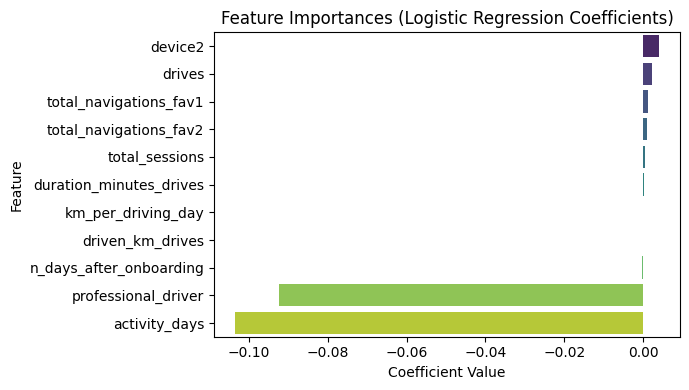

In [37]:
# Plot the feature importances
plt.figure(figsize=(7, 4))

# Plot sorted coefficients
sns.barplot(
    x="Coefficient",
    y="Feature",
    data=coef_df_sorted,
    hue="Feature",
    palette="viridis"
)

plt.title("Feature Importances (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### **Conclusion**

**Questions:**

1. What variable most influenced the model's prediction? How? Was this surprising?

The variable that most influenced the model's prediction was activity_days, with a strong negative coefficient (-0.103446). This means users with more activity days were less likely to be retained, which is not surprising because earlier we dentified that long-distance drivers and low-frequency users were more likely to churn.

2. Were there any variables that we expected to be stronger predictors than they were?

Yes. Based on earlier analysis, I thought km_per_driving_day would be more important. It had the strongest positive correlation with churn, but in the model, it turned out to be one of the least important features.

3. Why might a variable we thought to be important not be important in the model?

In logistic regression, variables can affect each other. Sometimes when we look at all variables together, a feature that seemed important by itself becomes less important because of interactions.

4. Would we recommend that Waze use this model? Why or why not?

If the model is for important business decisions, then no, because it doesn't predict very well (poor recall). But if it’s just to help with further exploration, then yes, it can still be useful.

5. What could we do to improve this model?

I would create new features using domain knowledge to better capture patterns. Scaling the features or trying different combinations of variables might also help remove noise and make the model better.

6. What additional features would we like to have to help improve the model?

IAdditional features like user engagement metrics (e.g., session duration, frequency of app features used), demographic data (e.g., age, location), and device-specific behaviors could help improve the model by providing more context on user behavior.